In [1]:
# data retrieval
import requests

# data storage and manipulation
import numpy as np
import pandas as pd

# functional tools to allow for model fine tuning
from functools import partial, update_wrapper

# modeling and validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix, \
                            f1_score

# from my modeling repo
from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves

In [2]:
%matplotlib inline

### --------------------------------------------------------------

# Census Data Analysis

### --------------------------------------------------------------

# 0. Overview

### Prerequisites

This notebook contains the results of a quick exercise in data analysis and prediction, with the goal being to develop a model to predict whether a given person, based on the provided data, makes more than \$50K per year.

Depending on which version of Jupyter Notebook you are running, you may have to increase your data transmission limits in order to be able to download the dataset within the confines of the notebook, which is what I have done here. This can be achieved through passing a new limit to the *NotebookApp.iopub_data_rate_limit* option while launching Jupyter Notebook from the command line:
    
    jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

The original dataset and description can be found at: https://archive.ics.uci.edu/ml/datasets/Adult

### Analysis Description

I put together this analysis in an effort to showcase some analysis & ML validation modules that I have been working on. The Notebook has 3 parts:

1) Get Data
- Pull dataset from the UC Irvine website
- Check for and deal with duplicates and nulls
- Slight reworking of table
    
    
2) Exploratory Data Analaysis
- Investigate certain features, looking for relationships with income level
- The approach taken here is very visual
- Descriptive statistics are also performed
    
    
3) Modeling
- Cross-validate a Random Forest Classifier
- Tune depth parameter to reduce overfitting
- Introduce example use case and develop appropriate cost function

# 1. Get Data

### Retrieve

In [3]:
def get_census_data():
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    r = requests.get(url, stream=True)
    results = [l.decode().split(',') for l in r.iter_lines()]
    r.close()
    return pd.DataFrame(results, columns=cols)

In [4]:
table = get_census_data()

In [5]:
table.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
table.to_csv("cencus_data.csv")

In [7]:
len(table)

32562

### Check for problems

#### Duplicates

In [8]:
len(table[table.duplicated()])

24

In [9]:
table = table.drop_duplicates()

#### Nulls

In [10]:
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

In [11]:
table[table.workclass.isnull()]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32561,,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [12]:
table[~table.index.isin((32561,))].isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

In [13]:
table = table[~table.index.isin((32561,))].reset_index(drop=True)

### Set up data types

In [14]:
table.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

In [15]:
int_cols = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

In [16]:
table.loc[:, int_cols] = table.loc[:, int_cols].astype(int)

### Set up response column

In [17]:
table.over_fifty_k.value_counts()

 <=50K    24698
 >50K      7839
Name: over_fifty_k, dtype: int64

In [18]:
table.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In [19]:
table.over_fifty_k = table.over_fifty_k.map(lambda _:
                                            1 if _ == ' >50K'
                                            else 0)

# 2. Exploratory Data Analysis

In [20]:
table.over_fifty_k.value_counts() / len(table)

0    0.759074
1    0.240926
Name: over_fifty_k, dtype: float64

#### Notes

The classes are imbalanced, appearing here at a ratio of 3: 1 negative: postitive.

### Age

In [21]:
table.age.nunique()

73

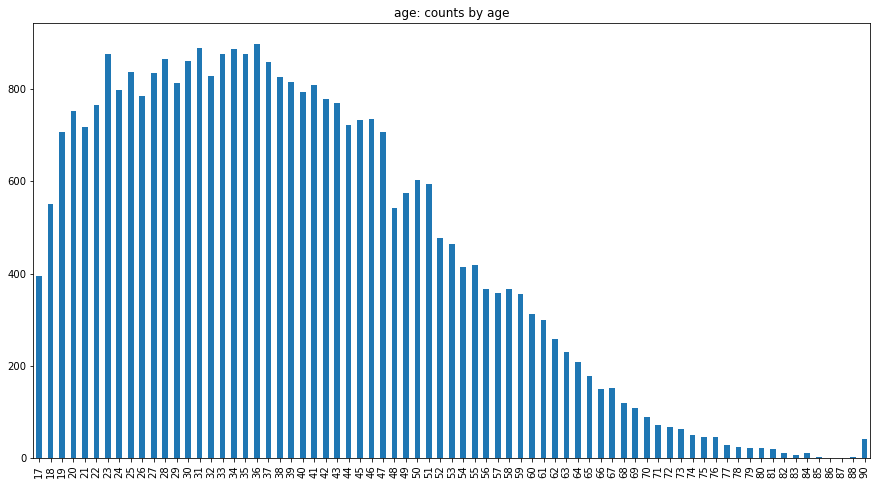

In [22]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8))
ax.title.set_text('age: counts by age')

#### Notes
    
The *age* data looks to be positively skewed, and has a floor of 17.

We can look, in more detail, at the distribution of the *age* data, this time with overlays for the data's mean and strandard deviation, using the `center_scale_plot` function from the **exploratory** module. 

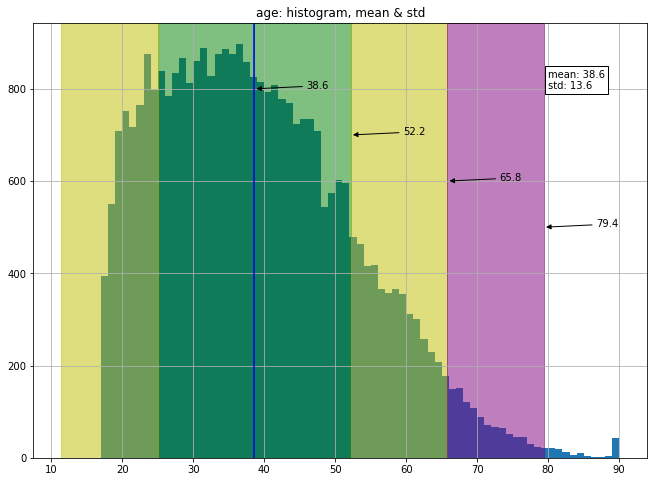

In [23]:
exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

In [24]:
len(table[table.age > 79]) / len(table)

0.0036881089221501677

#### Notes
    
A couple of observations:
- roughly 99.6% of the data falls within 3 standard deviations of the mean, which is 38.6 years
- the concentration of data with age 90 might indicate that age was off at 90

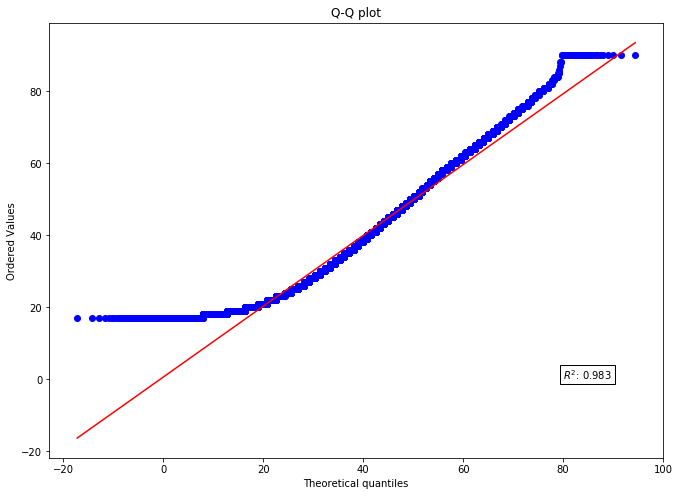

In [25]:
exploratory.qq_plot(table.age.astype(int))

#### Notes

We can use a Q-Q, or quantile-quantile, plot, which in this case plots the quantiles of our data against the quantiles of a Normal distribution with the same mean and standard deviation, to assess whether the data is Normally distributed.

We have an $R^2$ of over 98%, as the vast majority of the data, particularly the data close to the mean, fits the Normal distribution (the straight red line) quite well. However, we can see clearly here the deviation from the Normal distribution that occurs in the tails, especially in the left tail.

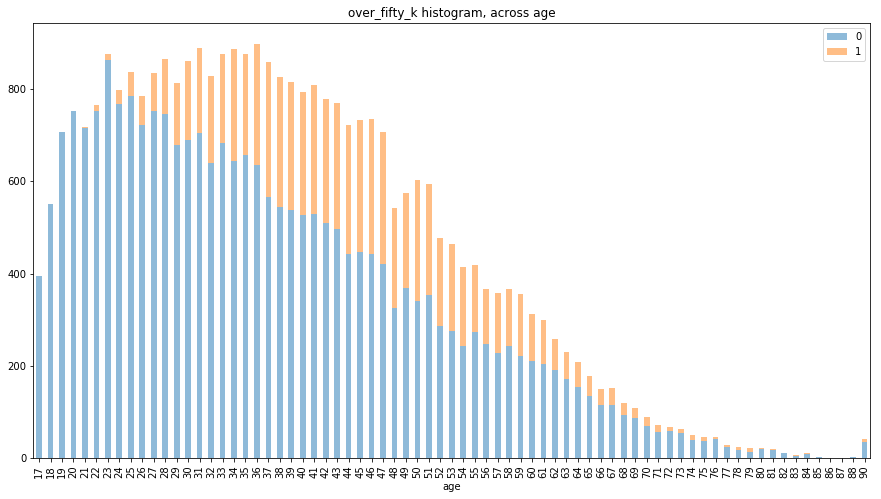

In [26]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 'age', figsize=(15, 8))

#### Notes

Breaking down age by income, we can see that the bulk of the >=50K higher earners are middle-aged.

In [27]:
table['age'] = table.age.astype(int)

### Education

In [28]:
table.education.nunique()

16

In [29]:
ed = table[['education', 'education_num']
          ].drop_duplicates().set_index('education', 
                                        drop=True)

In [30]:
ed['education_num'] = ed['education_num'].astype(int)

In [31]:
ed.sort_values('education_num')

,education_num
education,
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


#### Notes

There is a one-to-one mapping of *education* to *education_num*. We can retain the ordering here for future analysis of the *education* field. 

In [32]:
table.education = pd.Categorical(table.education, 
                                 ed.sort_values('education_num').index)

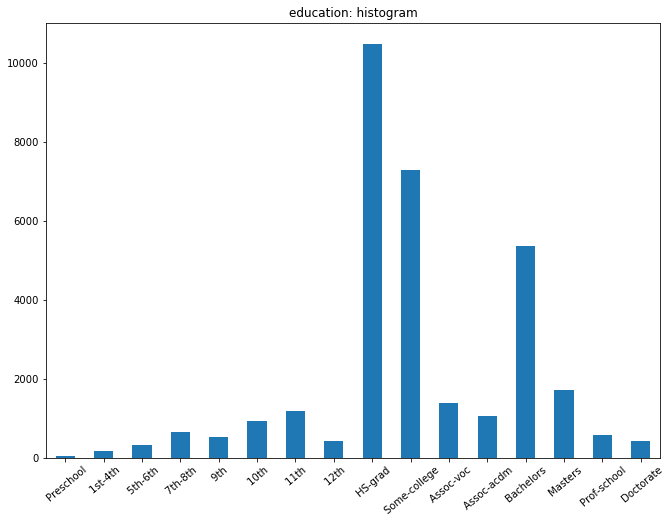

In [33]:
ax = table['education'].value_counts(
                      ).sort_index(
                      ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('education: histogram')

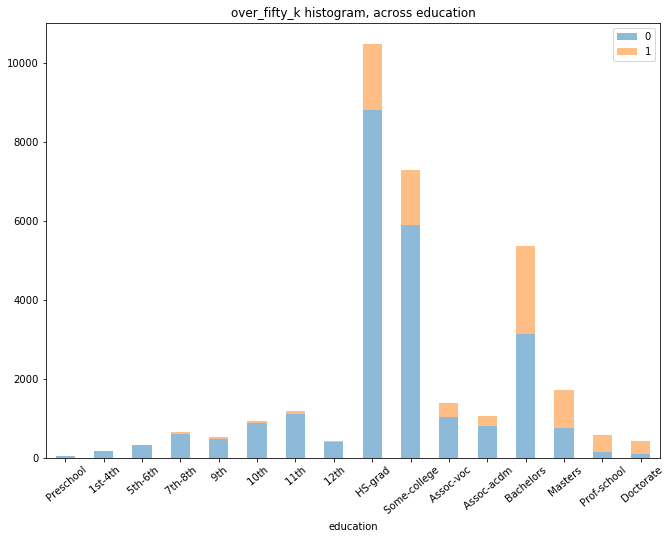

In [34]:
exploratory.feature_hist_by_class(table, 'over_fifty_k',
                                  'education', rot=40)

In [35]:
table['education_num'] = table.education_num.astype(int)

#### Notes

High income is much more prevalent amongst the more-educated. 

### Education vs. age, by income class

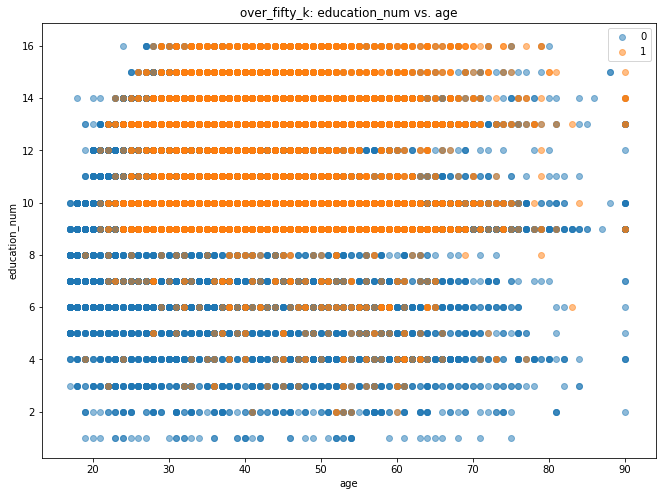

In [36]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'education_num')

#### Notes

The more brownish regions in the above plot indicate an overlap between the classes. The bright orange here could indicate some pockets of predominantly over 50K earners. Let us continue examining other variables to see if a decision boundary becomes more clear. 

### Work class

In [37]:
table.workclass.nunique()

9

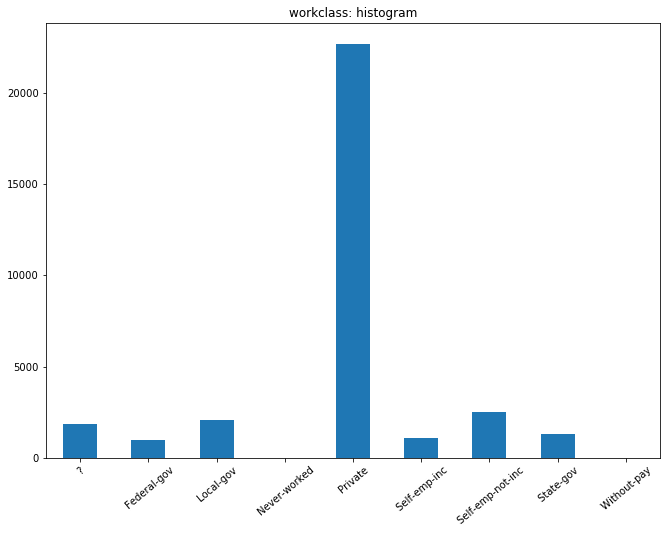

In [38]:
ax = table['workclass'].value_counts().sort_index(
                        ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('workclass: histogram')

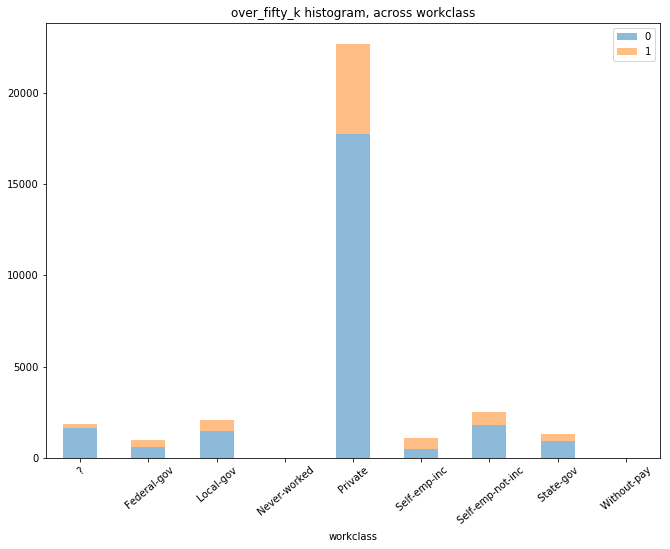

In [39]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 
                                  'workclass', rot=40)

#### Notes

Private sector employment seems to be housing the bulk of the high earners, though most of the people employed by the private sector in fact do not fall into the over \$50K bucket.

### Final weight

#### Notes

The UCI documentation describes this column as reflecting a by-state population demographic weight. Let's take a look at how this data is distributed. 

In [40]:
table.fnlwgt.nunique()

21648

In [41]:
table.fnlwgt = table.fnlwgt.astype(int)

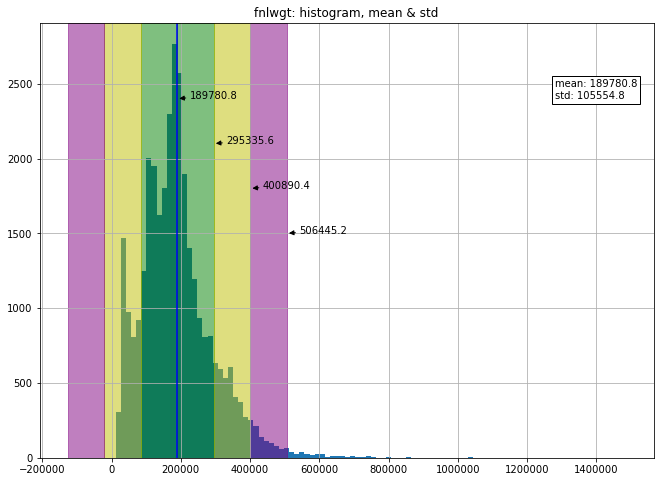

In [42]:
exploratory.center_scale_plot(table.fnlwgt, np.mean, np.std, bins=100)

In [43]:
len(table[table.fnlwgt > 506445]) / len(table)

0.01063404739219965

#### Notes

The final weight data exhibits strong positive skewness.

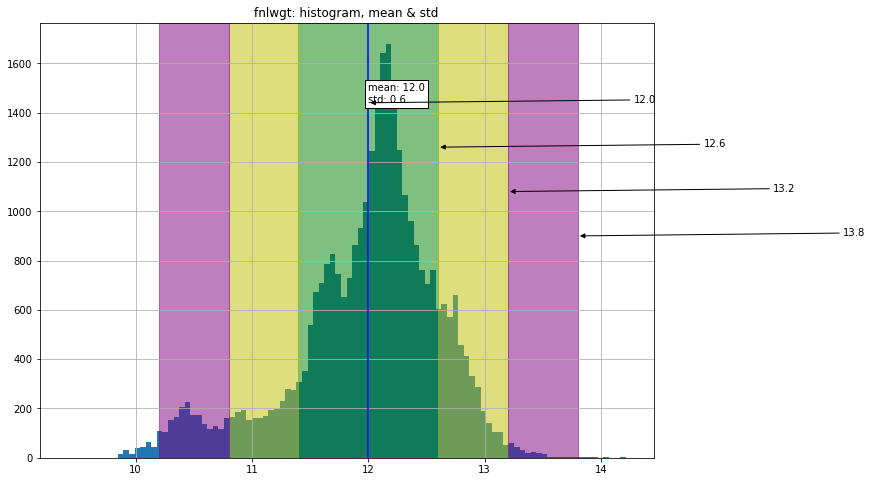

In [44]:
exploratory.center_scale_plot(np.log(table.fnlwgt), np.mean, np.std, bins=100)

#### Notes

Taking the log transform has yielded a more symmetrical dataset that sits almost entirely within 3 standard deviation bands.

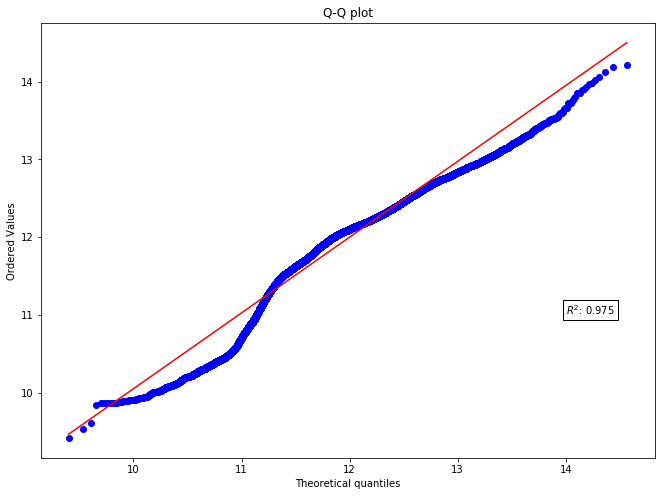

In [45]:
exploratory.qq_plot(np.log(table.fnlwgt))

#### Notes

Plotting the ordered final weight data against the quantiles of a Normal distribution with the same location and center, we achieve a high goodness-of-fit measure. The unusual lump in the data's left tail stands out on this QQ plot as it did on the above histogram. 

In [46]:
table['fnlwgt_log'] = np.log(table.fnlwgt)

### Final weight vs. age, by income class

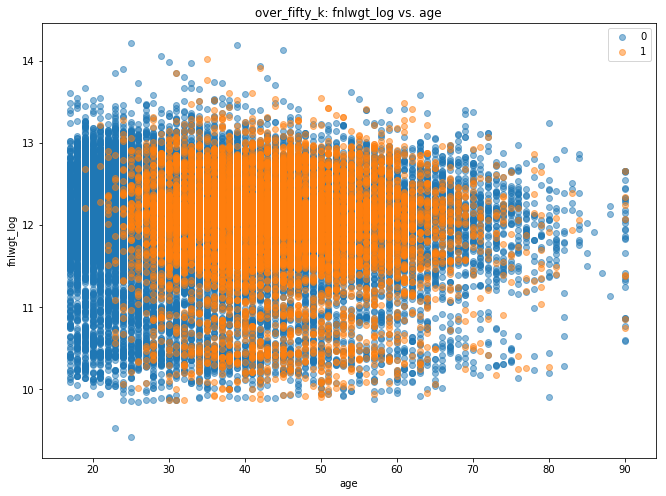

In [47]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'fnlwgt_log')

#### Notes

There is definitely some overlap between age and fnlwgt.

### Final weight vs. education, by income class

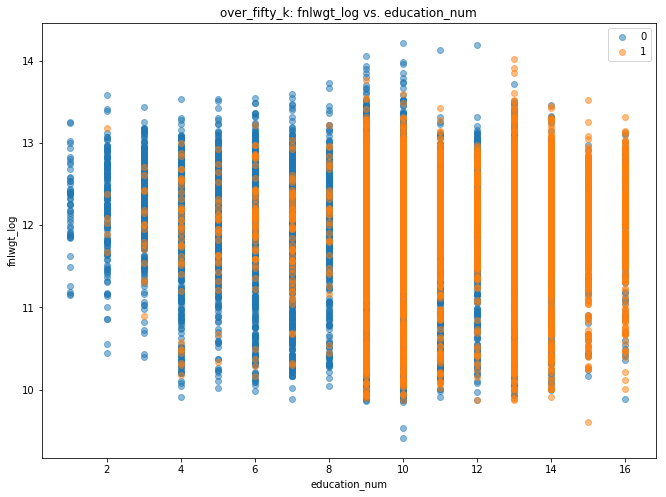

In [48]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'education_num', 'fnlwgt_log')

#### Notes

It appears that the combination of fnlwgt & education, as with age & education, may provide some decent class differentiation, although there is still a good bit of overlap.

# 2. Modeling

#### Notes

I am going to keep it simple: one-hot encode the categorical variables, leave the rest in their original states, and see what kind of results can be achieved using a Random Forest Classifier. 

A Decision Tree works by repeatedly splitting a dataset, 20- questions-style, in an effort to find feature values by which the dataset can be seperated into its proper classes. A Random Forest works by creating many different Decision Trees and then either averaging or taking the mode of the results, depending on whether you're performing regression (continuous responses) or classification (categorical responses).

RFCs can handle complex decision boundaries, they require little with respect to both data prep and hyperparameter tuning, and they can handle class imbalances in a straightforward manner, through forcing particular class balances in the bootsrap sampling used to generate the internal trees (in this case, we will specify a *balanced* subsample). For these reasons, I think that an RFC will make for a nice first pass here.

### Function to get modeling data

In [49]:
def get_model_data(table, features, dont_dummy):
    cols = ['over_fifty_k'] + features
    for_modeling = table[cols]
    to_dummy = list(filter(lambda _: _ not in dont_dummy, cols))
    return pd.get_dummies(for_modeling, columns=to_dummy)

### Prep

In [50]:
table.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'over_fifty_k', 'fnlwgt_log'],
      dtype='object')

In [51]:
table.dtypes

age                  int64
workclass           object
fnlwgt               int64
education         category
education_num        int64
marital_status      object
occupation          object
relationship        object
race                object
sex                 object
capital_gain        object
capital_loss        object
hours_per_week      object
native_country      object
over_fifty_k         int64
fnlwgt_log         float64
dtype: object

In [52]:
table[['capital_gain', 
       'capital_loss',
       'hours_per_week']] = table[['capital_gain', 
                                   'capital_loss',
                                   'hours_per_week']
                                  ].astype(int)

In [53]:
int_cols = list(table.dtypes[table.dtypes=='int64'].index.values)

In [54]:
int_cols

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'over_fifty_k']

In [55]:
X = ['age', 'workclass', 'fnlwgt', 'education_num',
     'marital_status', 'occupation', 'relationship', 
     'race', 'sex', 'capital_gain', 'capital_loss', 
     'hours_per_week', 'native_country']

### Get data

In [56]:
for_modeling = get_model_data(table, X, int_cols)

In [57]:
len(for_modeling.columns)

93

In [58]:
X_model = [col for col in for_modeling.columns if col != 'over_fifty_k']

In [59]:
cv, final = train_test_split(for_modeling.index, test_size=.20, 
                             stratify=for_modeling.over_fifty_k)

In [60]:
final = for_modeling.loc[final, :]

In [61]:
for_modeling = for_modeling.loc[cv, :]

### Cross validate

#### Notes

Cross validation involves slicing the data into *k* pieces (in this case 5) and, for each of the *k* folds, holding that fold out as a test set (the model will not have been trained on that data) and training on the rest. 

The results for the tests on each of the folds are then averaged. This methodology solves 2 common problems in model selection: 

- you can't depend on performance figures that stem from predicting the data the model was trained on

- which data you test on and how much you use for training can bias results and leave you without much to test on

We will perform our cross validation on 80% of the data (saved into the `for_modeling` variable) and we will perform our final tests on the remaining 20% (`final`) so as to avoid testing on the data that we used to pick our optimial model.

In [62]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                                  class_weight='balanced_subsample'),
                                 X=for_modeling[X_model],
                                 y=for_modeling.over_fifty_k,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score])

In [63]:
results[['mean', 'std']]

mean       std
accuracy_score  train  0.999971  0.000026
                test   0.854816  0.004292
precision_score train  1.000000  0.000000
                test   0.741237  0.010585
recall_score    train  0.999880  0.000109
                test   0.610590  0.014879

#### Analysis

We've trained and tested here a Random Forest classifier with 2 hyper parameters passed:

- `n_estimators` determines the number of Decision Trees built

- `class_weight` with value *balanced_subsample* tells the algorithm to build its trees using class-balanced subsamples

Our test *accuracy* of ~85.5% is on par with the results posted by this dataset's curator. But there are a couple of issues with these results:

- there is a large disparity between train and test results for all 3 of the scores we've calculated

- *accuracy*, especially when dealing with imbalanced classes, can be a very misleading metric

I've included *accuracy* as sort of a quick-n-dirty guide, but the *precision* and *recall* scores here are more important as they are based off of the results for the positive, over \$50K annually, class, which is underrepresented in the dataset. 

*Precision* tells us how reckless the model was in making its positive predictions. The higher the score, the more careful the model. *Recall* tells us how much money was left on the table, so to speak. The higher the *recall*, the greater the percent of all positive class instances identified.

We can attempt to implement some prepruning, which means limiting the growth of the RFC's internal Decision Trees, in an effort to curb the overfitting. 

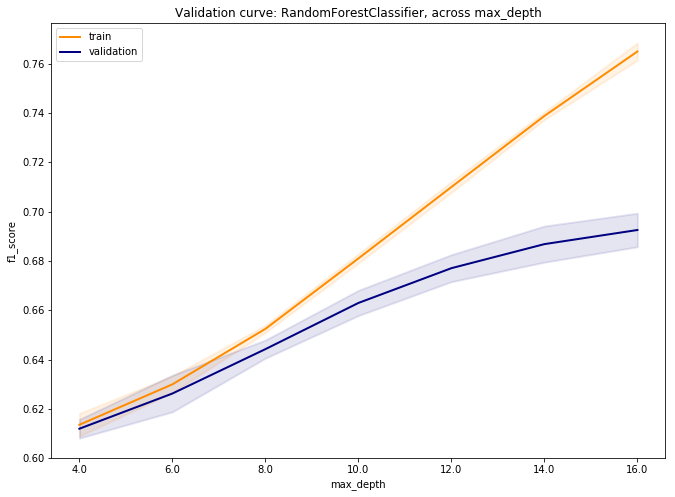

In [64]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=for_modeling[X_model],
                        y=for_modeling.over_fifty_k,
                        param_name='max_depth',
                        param_range=np.linspace(4, 16, 7),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score=f1_score)

#### Analysis

The above validation curve plots cross validation performance for the model across different levels of prepruning. The lower `max_depth` is, the stronger the prepruning. As `max_depth` increases, the train and test scores diverge, which is a good sign of overfitting.

The performance metric being used here is called *f1 score*. f1 is the harmonic mean of precision and recall, which means that if you have to choose one number, this is a good way to go as it accounts for both care and thoroughness, so to speak. Additionally, this measure is calculated on the positive class, which means that we will know if our model is simply dumping all predictions into the negative class bucket. 

I am going to continue validation with a `max_depth` of 14, as the train and test divergence is still pretty tame (within 5%), and there does appear to be a gain in validation performance between a `max_depth` of 12 and 14.

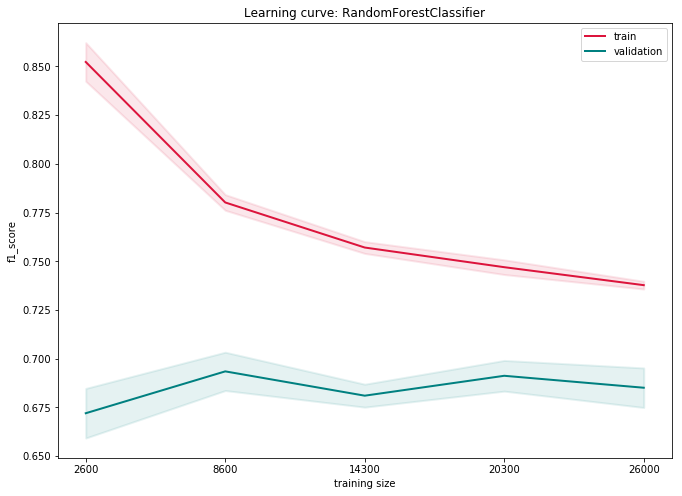

In [65]:
curves.learning_curve(model_type=RandomForestClassifier,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':100,
                                    'max_depth': 14},
                      X=for_modeling[X_model],
                      y=for_modeling.over_fifty_k,
                      score=f1_score)

#### Analysis

In the above learning curve, the model is trained and tested over varying amounts of training data. 

There is some overfitting, but the validation results are consistent even at small training sizes. 

A good slope in the validation scores generally indicates that the model has fit the data well - the more information it recieves, the better it does. In this case, we may be underfitting the data a bit. 

In other words, we may be both overfitting and underfitting: the model has learned more about the training data set than it has about the data in general, and the model also does not seem to be making the most out of its access to more information.

At the same time, the model is providing very consistent results. The fact that the model is putting up decent performance when trained on roughly 10% of the dataset is a good indicator of stability. 

With this model, we know what we are getting, and we did not have to do anything to the data that might make our results less reliable or difficult to replicate in any way, which is valuable. At this point, for the purposes of a quick analysis, I like this model and will continue diving further into its performance.

In [66]:
crossvalidate.cv_conf_mat(model_obj=RandomForestClassifier(n_estimators=100,
                                                           class_weight='balanced_subsample',
                                                           max_depth=14),
                          X=for_modeling[X_model],
                          y=for_modeling.over_fifty_k,
                          splits=3)

neg_pred  pos_pred
1 neg_true      5317      1269
  pos_true       324      1767
2 neg_true      5196      1390
  pos_true       268      1822
3 neg_true      5305      1281
  pos_true       330      1760

#### Analysis

To really come to an opinion on how a model's working, it is good to take a look at what it's putting where, which is what the above confusion matrices show us (1 for each of 3 trials). It doesn't seem like anything crazy is happening - these numbers reflect what we'd expect from the aggregate scores we looked at above.

### Test situation
    
Taking the confusion matrix further, one can put a value on each correct or incorrect prediction. This makes the notion of a score less abstract and more aligned with a business objective.

Example: you are selling insurance to people, and these people will only buy your insurance if they are making more than \$50K annually. It will cost you \$100 to advertise this insurance to them, and you will make \$1000 if a potential client converts. 

#### Set up cost funcs

In [67]:
def cost(true, pred):
    # true negative, no cost
    if true == 0 and pred == 0:
        return 0
    # false positive, lose $100 to advertising
    elif true == 0 and pred == 1:
        return 100
    # false negative, missed out on a grand
    elif true == 1 and pred == 0:
        return 1000
    # true positive, spend $100 to get $1000
    elif true == 1 and pred == 1:
        return -900

In [68]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [69]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                  class_weight='balanced_subsample',
                                                  max_depth=14),
                                X=for_modeling[X_model],
                                y=for_modeling.over_fifty_k,
                                score_funcs=[model_cost])

In [70]:
results[['mean', 'std']]

mean           std
model_cost train -3491100.0  29077.998556
           test   -701280.0  25899.652507

#### Analysis

We've set up an aggressive cost function here where poor *recall* is heavily penalized, which makes sense given the business model. Fortunately, our model is coming in on the right side of zero (this is a measurement of cost so negative is good). 

It's worth noting that there's a large disparity between train and test error. This could be an indication of overfitting. That said, the standard deviation, proportionately speaking, is quite small. Both of these qualities, overfitting but also consistency - were revealed to us in our learning curve analysis above. 

#### Train / test disparity

I wonder if the disparity between train and test costs may have something to do with the larger size of the training set? (this is an absolute, not %, cost)

In [71]:
results.loc[('model_cost', 'test'), 'mean'
           ] / results.loc[('model_cost', 'train'), 'mean']

0.2008765145656097

Our train data sets used in the CV contained 4 times as much data as our test set did, and our train score is about 5 times our test score. So we are overfitting , but only by, let's say, 4 or so percent.

#### Next steps

One thing we can do to optimize our cost here is tweak our decision boundary. *sklearn's* models default to a boundary of .5 for binary classification. Since we are much more interested in *recall* than *precision* (we want to nail as many positives as possible and are OK with some false positives) we can lower that decision bounday a bit. Or in other words, we're going to tell the model to be a little more aggressive in looking for positive classifications. 

We will start with a decision boundary of 40%.

### Adjust boundaries

#### New RF Classifier that predicts probabilities

To do this, we are going to have to put a wrapper around the *sklearn* Random Forest class. I built my cross-validation tools to (for now) expect models with an API similar to that of the *sklearn* models, which means they are looking for every model to have a predict method. However, we can change the functionality of a model's predict method so that it predicts class probabilities instead of labels. 

**Note**: I have left this boundary analysis broken out into pieces here in the notebook, but the **indoorplants.boundaries** module provides tools for evaluating binary classifier performance using adjusted decision boundaries.

In [72]:
class RFProb(RandomForestClassifier):
    def predict(self, X):
        return self.predict_proba(X)

#### Modify cost mechanisms to convert probability to label

In [73]:
def prob_to_class(func):
    def convert(y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > .4 else 0)
        return func(y_true, conv(pos_class))
    return convert

In [74]:
@prob_to_class
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [75]:
results = crossvalidate.cv_score(model_obj=RFProb(n_estimators=100,
                                 class_weight='balanced_subsample',
                                 max_depth=14),
                                 X=for_modeling[X_model],
                                 y=for_modeling.over_fifty_k,
                                 score_funcs=[model_cost])

In [76]:
results[['mean', 'std']]

mean           std
convert train -3778840.0  10022.873839
        test   -802140.0  20064.346488

In [77]:
-1012880.0 / -891700.0

1.1358977234495906

#### Notes

We have seen an improvement here, subtracting roughly 14% from our test cost. We can push this boundary even further if we'd like.

#### Rework functions to allow for testing across passed thresholds

In [78]:
def cost(true, pred):
    if true == 0 and pred == 0:
        return 0
    elif true == 0 and pred == 1:
        return 100
    elif true == 1 and pred == 0:
        return 1000
    elif true == 1 and pred == 1:
        return -900

In [79]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

In [80]:
def prob_to_class(t, func):
    def convert(t, y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > t else 0)
        return func(y_true, conv(pos_class))
   
    def threshold(t):    
        partial_func = partial(convert, t)
        update_wrapper(partial_func, convert)
        return partial_func
    
    return threshold(t)

In [81]:
def boundary_cost(t):
    return prob_to_class(t, model_cost)

#### Function to cross validate over multiple boundaries: 25% to 55% 

In [82]:
def test_boundaries():
    i, results = .55, {}
    while i > .25:
        results[i] = crossvalidate.cv_score(
                            model_obj=RFProb(n_estimators=100,
                                             class_weight='balanced_subsample',
                                             max_depth=14),
                            X=for_modeling[X_model],
                            y=for_modeling.over_fifty_k,
                            score_funcs=[boundary_cost(i)])
        i -= .05
    return pd.concat(results)

#### Run cross validation

In [83]:
results = test_boundaries()

In [84]:
results[['mean', 'std']]

mean           std
0.25 convert train -3866840.0  12691.059845
             test   -881060.0  13521.390461
0.30 convert train -3858800.0   7693.828696
             test   -858240.0  16689.158157
0.35 convert train -3839100.0   6825.320505
             test   -829500.0  15616.657773
0.40 convert train -3781740.0  10372.704565
             test   -802760.0  13649.102535
0.45 convert train -3654880.0  22333.315920
             test   -762740.0  26429.396512
0.50 convert train -3459760.0  26396.268676
             test   -699180.0  27822.239306
0.55 convert train -3173880.0   8645.056391
             test   -613580.0  39609.115113

In [97]:
-3839100.0 / -3866840.0

0.9928261836538362

In [98]:
6825.320505 / 12691.059845

0.5378053991045536

#### Analysis

The minimum cost here occurs with a decision boundary of 25%. I will continue onwards with a decision threshold of 35%, as, when compared to a 25% probability for the positive-class cutoff, this increases our expected cost by less than 1% but cuts our standard deviation almost in half.

### Train and test final model

#### Instantiate model

In [87]:
model = RFProb(n_estimators=100,
               class_weight='balanced_subsample',
               max_depth=14)

#### Train

In [88]:
model = model.fit(for_modeling[X_model], for_modeling.over_fifty_k)

#### Predict

In [89]:
y_pred = model.predict(final[X_model])

#### Threshold

In [90]:
def convert(t, y_pred):
    pos_class = y_pred[:, 1]
    conv = np.vectorize(lambda _: 1 if _ > t else 0)
    return conv(pos_class)

In [99]:
y_pred_class = convert(.35, y_pred)

#### Analysis

In [100]:
conf_mat = confusion_matrix(final.over_fifty_k, y_pred_class)

In [101]:
conf_mat

array([[3370, 1570],
       [  87, 1481]])

In [102]:
boundary_cost(.35)(final.over_fifty_k, y_pred)

-1088900

In [103]:
'recall: {}'.format(conf_mat[1][1] / conf_mat[1, :].sum())

'recall: 0.9445153061224489'

In [104]:
'precision: {}'.format(conf_mat[1][1] / conf_mat[:, 1].sum())

'precision: 0.485414618157981'

Testing on our held-out 20% (stratified & randomly selected) of the dataset, we've achieved a *recall* score of roughly 94%.